In [1]:
import numpy as np
from sklearn.datasets import make_spd_matrix
import cvxpy as cp
import time
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
np.random.seed(42)

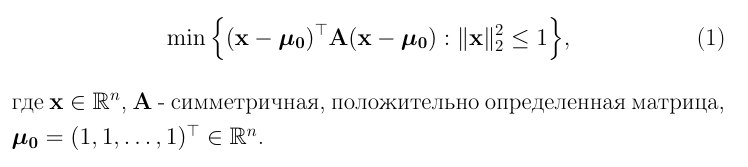

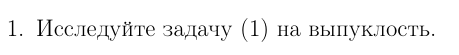

Функция $f(x)$ является квадратичной формой относительно $x$. 
Гессиан (вторая производная) этой функции $H(x) = 2A$. По условию матрица $A$ положительно определена, а значит и матрица $2A$ тоже положительно определена. Из этого следует, что функция $f(x)$ является выпуклой.

Ограничение можно записать как $g(x) = x^Tx \le 1$. Первая производная равна $2x$, а гессиан равен $2I$, где $I$ - единичная матрица. $2I$ положительно определена, а значит $g(x)$ - выпуклая функция. Из этого следует, что и ограничение $g(x) \le 1$ - выпуклое множество. Также можно сказать, что это это множество соответствует единичному шару в $\mathbb{R}^n$.

Таким образом, поскольку и функция цели, и множество ограничений выпуклы, оптимизационная задача является выпуклой.

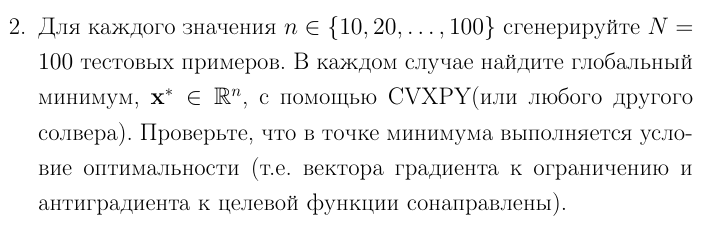

Функция для решения с помощью солвера cvxpy

In [3]:
def solve_elipsoid(A, mu):

    x = cp.Variable(A.shape[0])

    objective = cp.Minimize(cp.quad_form(x - mu, A))

    constraints = [cp.norm2(x) <= 1]

    prob = cp.Problem(objective, constraints)

    result = prob.solve()

    return [x.value, result]

Функция для сохранения решений n тестовых с разными матрицами одной размерности

In [4]:
def solve_rand_elipsoids(
    n_dim: int = 2, n_samples: int = 100, random_states: list = None
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]

    cases = []

    for A in affine_ops:

        cases.append([A] + list(solve_elipsoid(A, mu)))

    return cases

In [5]:
def quadform_grad(A, x, mu):
    return (A + A.T) @ x - (A + A.T) @ mu

In [6]:
def constraint_grad(x):
    return 2 * x

Проверка оптимальности

In [7]:
def is_kkt_optimal(grad_obj, grad_constraint, eps=0.01):

    dot = np.dot(-grad_obj, grad_constraint)
    norm_f = np.linalg.norm(grad_obj)
    norm_g = np.linalg.norm(grad_constraint)
    if norm_f < eps or norm_g < eps:
        return True
    cos_angle = dot / (norm_f * norm_g)

    return bool((np.abs(cos_angle - 1) < eps).all())

In [8]:
ndims = range(10, 110, 10)

Генерируем 100 примеров для каждой из размерностей и решаем их с пмощью солвера

In [9]:
print("+---------------------------------------+")
for dim in ndims:
    mu = np.ones(dim)
    time_start = time.time()
    all_optim_flag = np.all(
            np.asarray(
                [
                    is_kkt_optimal(
                        quadform_grad(case[0], case[1], mu), constraint_grad(case[1])
                    )
                    for case in solve_rand_elipsoids(dim)
                ]
            )
        )
    time_total = (time.time()-time_start)

    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    print(
        f"| dim={dim_str} | {all_optim_flag} | avg_time: {time_total/100:.4f} sec |",
    )
print("+---------------------------------------+")

print("^_^")

+---------------------------------------+
| dim=10  | True | avg_time: 0.0111 sec |
| dim=20  | True | avg_time: 0.0064 sec |
| dim=30  | True | avg_time: 0.0083 sec |
| dim=40  | True | avg_time: 0.0093 sec |
| dim=50  | True | avg_time: 0.0109 sec |
| dim=60  | True | avg_time: 0.0125 sec |
| dim=70  | True | avg_time: 0.0176 sec |
| dim=80  | True | avg_time: 0.0200 sec |
| dim=90  | True | avg_time: 0.0202 sec |
| dim=100 | True | avg_time: 0.0787 sec |
+---------------------------------------+
^_^


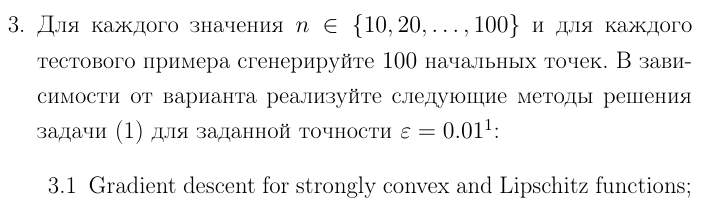

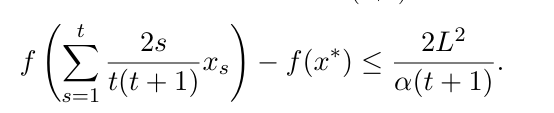

Реализация метода градиентного спуска для сильно выпуклых и Липшицовых функций

In [10]:
def project_to_constraint(x):
    x_norm = np.linalg.norm(x)
    return x if x_norm <= 1 else x / x_norm

def gradient_descent(A, mu, x_init, f_star, eps=0.01, max_iters=10000, return_history=False):
    
    # alpha = np.min(np.linalg.eigvals(A*2))
    alpha = np.min(np.diagonal(2*A))

    lr = 2 / alpha

    x = x_init.copy()
    iterations = 0
    precision_history = [(x - mu).T @ A @ (x - mu) - f_star]
    while iterations < max_iters:

        grad = quadform_grad(A, x, mu)
        x_new = project_to_constraint(x - lr/(iterations+1) * grad)
        f_val = (x_new - mu).T @ A @ (x_new - mu)
        
        # print('---------------')
        # print('x: ', x_new)
        # print('f: ', f_val)
        # print('---------------')

        x = x_new
        iterations += 1

        precision_history.append(abs(f_val - f_star))
        
        if abs(f_val - f_star) <= eps:
            break

    if return_history:
        return x_new, iterations, f_val, precision_history
        
    return x_new, iterations, f_val

Функция для генерации и решения примеров методом градиентного спуска

In [11]:
def gd_rand_elipsoids_avg_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    iters_total = 0
    time_total = 0

    for A in affine_ops:

        solution = solve_elipsoid(A, mu)

        case_time_start = time.time()

        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            iters_total += iters
            
        time_total += time.time() - case_time_start

    return time_total/(n_samples*n_init_states) , iters_total/(n_samples*n_init_states)

Генерируем 100 примеров для каждой размерности и 100 начальных точек для каждого примера и сохраняем статистики (сюда также входит пункт 5.1, мы выводим среднее время и количество итераций для нашего метода градиентного спуска)

In [12]:
print("+-----------------------------------------------------+")
for dim in ndims:
    
    dim_str = str(dim)

    if len(dim_str) < 3:
        dim_str+=" "

    stat = gd_rand_elipsoids_avg_stats(dim)

    print(
        f"| dim={dim_str} | avg_iters: {stat[1]:.4f} | avg_time: {stat[0]:.4f} sec |",
    )
print("+-----------------------------------------------------+")

print("^_^")

+-----------------------------------------------------+
| dim=10  | avg_iters: 10.4891 | avg_time: 0.0002 sec |
| dim=20  | avg_iters: 16.7969 | avg_time: 0.0003 sec |
| dim=30  | avg_iters: 20.9292 | avg_time: 0.0004 sec |
| dim=40  | avg_iters: 21.6300 | avg_time: 0.0005 sec |
| dim=50  | avg_iters: 24.7928 | avg_time: 0.0006 sec |
| dim=60  | avg_iters: 32.0057 | avg_time: 0.0008 sec |
| dim=70  | avg_iters: 30.9600 | avg_time: 0.0008 sec |
| dim=80  | avg_iters: 36.7400 | avg_time: 0.0010 sec |
| dim=90  | avg_iters: 37.3600 | avg_time: 0.0012 sec |
| dim=100 | avg_iters: 48.9664 | avg_time: 0.0077 sec |
+-----------------------------------------------------+
^_^


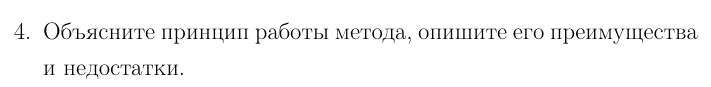

Метод основан на итеративном вычислении градиента функции, который указывает направление наибольшего роста функции. Двигаясь в противоположном направлении, алгоритм уменьшает значение функции на каждом шаге.

Сильная выпуклость функции гарантирует сходимость градиентного спуска к глобальному минимуму. Сильная выпуклость означает, что функция имеет единственный минимум, и градиентный спуск может эффективно найти его. 

Липшицевость означает, что градиент функции ограничен. Это свойство гарантирует, что градиентный спуск будет сходиться с контролируемой скоростью, поскольку изменения функции ограничены.

Преимущества:
- Согласно литературе сложность сходимости  O(1/(αε))
- Гарантированная сходимость к глобальному минимуму

Недостатки:
- Если функция гладкая, то градиентный спуск с постоянным шагом дает сложность сходимости O(β*α*log(1/ε)), что лучше чем у этого метода.

## 5

In [13]:
def gd_rand_elipsoids_sol_stats(
    n_dim: int = 2, n_samples: int = 100, n_init_states = 100, random_states: list = None, eps=0.01
):
    mu = np.ones(n_dim)

    if random_states is None:
        random_states = np.random.randint(0, 4294967295, size=n_samples)

    affine_ops = [make_spd_matrix(n_dim, random_state=state) for state in random_states]
    
    cases = []

    for i, A in enumerate(affine_ops):

        solution = solve_elipsoid(A, mu)

        eig_vigals = np.sort(np.abs(np.linalg.eigvals(A)))
        conditional_number = eig_vigals[-1] / eig_vigals[0]


        for _ in range(n_init_states):

            x_init = project_to_constraint(np.random.randn(n_dim))
            x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=eps)
            
            cases.append({
                "example_id" : i,
                "conditional_number": conditional_number,
                "Lipschitz_L" : eig_vigals[-1],
                "strong_convexity_alpha": np.min(np.diagonal(2*A)),
                "is_kkt_optimal": is_kkt_optimal(quadform_grad(A, x_opt, mu), constraint_grad(x_opt)),
                "solution_delta": np.abs(solution[-1] - f_val),
                "iters" : iters
            })

    return pd.DataFrame.from_records(cases)

In [14]:
dim_10_spectral_stats = gd_rand_elipsoids_sol_stats(10)

In [15]:
dim_10_spectral_stats

,example_id,conditional_number,Lipschitz_L,strong_convexity_alpha,is_kkt_optimal,solution_delta,iters
0,0,269.584847,10.357786,0.804102,True,0.006299,9
1,0,269.584847,10.357786,0.804102,True,0.003464,9
2,0,269.584847,10.357786,0.804102,True,0.006615,9
3,0,269.584847,10.357786,0.804102,True,0.006607,9
4,0,269.584847,10.357786,0.804102,True,0.006619,9
...,...,...,...,...,...,...,...
9995,99,51.057617,10.424980,0.740509,True,0.002401,17
9996,99,51.057617,10.424980,0.740509,True,0.002401,17
9997,99,51.057617,10.424980,0.740509,True,0.002401,17
9998,99,51.057617,10.424980,0.740509,True,0.002401,17


## 5.2
### Для одного тестового примера при n = 10 и нескольких различных начальных точек постройте зависимость точности от числа итераций.

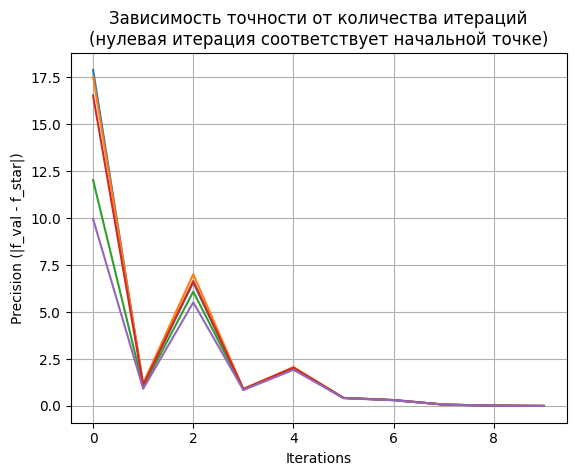

In [16]:
n_dim = 10

A = make_spd_matrix(n_dim, random_state=54)
mu = np.ones(n_dim)

solution = solve_elipsoid(A, mu)

n_init_states = 5

for _ in range(n_init_states):

    x_init = project_to_constraint(np.random.randn(n_dim))
    x_opt, iters, f_val, precision_history = gradient_descent(A, mu, x_init, solution[-1], eps=0.01, return_history=True)
    
    plt.plot(range(len(precision_history)), precision_history)

plt.grid(True)
plt.xlabel('Iterations')
plt.ylabel('Precision (|f_val - f_star|)')
plt.title('Зависимость точности от количества итераций\n(нулевая итерация соответствует начальной точке)')
plt.show()

### Зависит ли скорость сходимости метода от отношения максимального и минимального собственных чисел матрицы A?

In [17]:
dim_10_spectral_stats_agg = dim_10_spectral_stats.groupby("example_id").mean()

In [18]:
dim_10_spectral_stats_agg

,conditional_number,Lipschitz_L,strong_convexity_alpha,is_kkt_optimal,solution_delta,iters
example_id,,,,,,
0,269.584847,10.357786,0.804102,1.0,0.006503,9.00
1,83.820223,10.549249,0.953940,1.0,0.005479,5.92
2,730.794375,10.494132,0.980743,1.0,0.002289,3.88
3,37.427124,10.577378,1.002657,1.0,0.006688,7.98
4,106.570269,10.497433,0.983431,1.0,0.002968,14.00
...,...,...,...,...,...,...
95,127.984582,10.401638,0.637115,1.0,0.003794,2.00
96,134.639361,10.552064,0.767132,1.0,0.003259,10.99
97,89.529014,10.547020,1.074171,1.0,0.008271,9.98


Text(0, 0.5, 'Iterations')

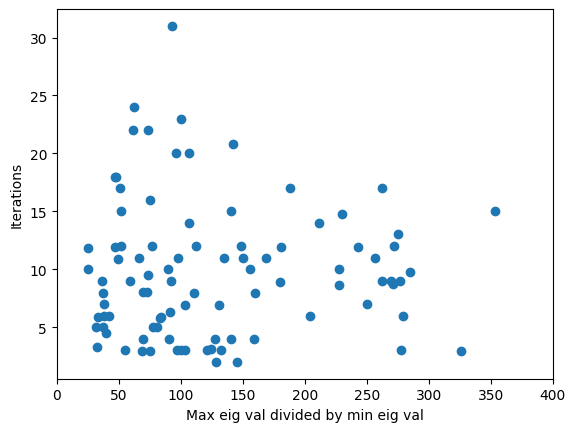

In [19]:
# plt.xscale('log')
plt.xlim((0, 400))
plt.scatter(dim_10_spectral_stats_agg["conditional_number"], dim_10_spectral_stats_agg["iters"])
plt.xlabel('Max eig val divided by min eig val')
plt.ylabel('Iterations')

На данном графике не очень отчетливо, но все же наблюдается следующая тенденция: чем больше отношение, тем больше итераций требуется методу, то есть тем медленнее сходимость. Это согласуется с выводами из литературы.

### Сравните полученные результаты с теоретическими верхними оценками

Возьмем 500 матриц размерностью 20x20 и сгенерируем по 100 начальных точек для каждой, найдем точки оптимума и сохраним количество итераций, а также коэффициент 1/(alpha*eps) и построим график, чтобы посмотреть, насколько в наших данных наблюдается данная асимптотическая зависимость.

In [20]:
n_dim = 20

estims = []
avg_iters = []

for i in range(500):

    A = make_spd_matrix(n_dim, random_state=np.random.randint(0, 4294967295))
    mu = np.ones(n_dim)
    
    alpha = np.min(np.diagonal(2*A))
    eps = 0.01
    
    estims.append(1 / (alpha * eps))

    solution = solve_elipsoid(A, mu)

    n_init_states = 5

    iters_sum = 0
    for _ in range(100):

        x_init = project_to_constraint(np.random.randn(n_dim))
        x_opt, iters, f_val = gradient_descent(A, mu, x_init, solution[-1], eps=0.01)
        
        iters_sum += iters
        
    avg_iters.append(iters_sum / 100)

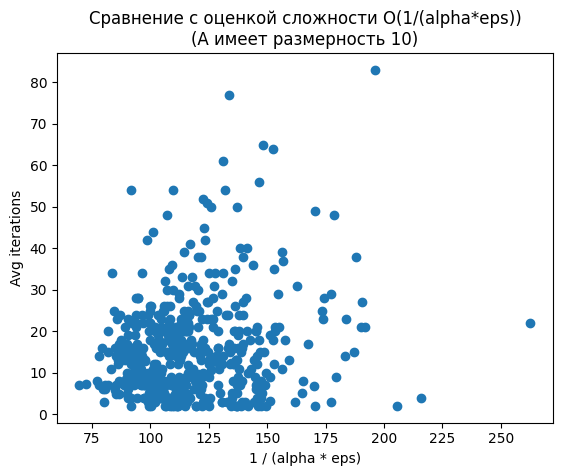

In [21]:
estims_iters = dict(zip(estims, avg_iters))
estims_iters = sorted(estims_iters.items())
estims_iters = {key : value for key, value in estims_iters}

plt.title('Сравнение с оценкой сложности O(1/(alpha*eps))\n(A имеет размерность 10)')
plt.xlabel('1 / (alpha * eps)')
plt.ylabel('Avg iterations')
plt.scatter(estims_iters.keys(), estims_iters.values())